In [303]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Parâmetros do problema
num_clients = 495
max_access_points = 30
grid_size = 400  # Tamanho do centro de convenções
max_distance = 85  # Distância máxima entre cliente e ponto de acesso
used_distance = 80
access_point_capacity = 54  # Capacidade máxima de cada ponto de acesso em Mbps

In [29]:
# Função para ler dados do arquivo CSV e normalizar coordenadas
def read_and_normalize_data(csv_file):
    # Ler arquivo CSV
    df = pd.read_csv(csv_file, header=None, sep=',', names=['client_x', 'client_y', 'client_demand'])

    # Extrair coordenadas dos clientes
    client_coordinates = df[['client_x', 'client_y']].values
    
    # Normalizar coordenadas para a escala do grid_size
    client_coordinates = client_coordinates / df[['client_x', 'client_y']].max().max() * grid_size
    
    # Extrair consumo de banda dos clientes
    bandwidth_demands = df['client_demand'].values

    # # Normalizar consumo de banda para estar entre 0 e 1
    # bandwidth_demands = df['client_demand'].values / df['client_demand'].max()

    return client_coordinates, bandwidth_demands

In [30]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
print(client_coordinates)

[[ 36.53221975 141.44182441]
 [ 68.07031582  53.44402491]
 [  1.2008702   65.7097847 ]
 [171.32854892  68.63544297]
 [ 90.23330249 113.75559501]
 [ 21.83491286 131.86967068]
 [ 86.04936111  72.54332225]
 [  7.82586082  64.1604361 ]
 [109.14455753 126.70850941]
 [ 70.94296217 116.18614188]
 [ 82.11847666 104.43349754]
 [ 98.11407567 243.36475707]
 [122.71761146  81.60336076]
 [ 39.51989198  97.08584431]
 [  6.64899602  75.84006401]
 [ 74.82183491 110.84494011]
 [ 38.86274412  53.76209647]
 [101.27278638 130.41934435]
 [ 25.47373159 171.49858718]
 [122.95766547  84.28296367]
 [ 95.34145183  76.60123528]
 [ 24.42749619  51.8386637 ]
 [ 64.1524343   56.33367508]
 [121.91743142  10.35532995]
 [201.36530719  77.33139956]
 [ 62.46005351  35.94108674]
 [149.13355505 142.82213498]
 [ 36.97531945  87.81175765]
 [ 90.3653322   82.76562227]
 [ 69.64066915 149.96374184]
 [ 97.03483284  17.56895301]
 [ 55.10639894  96.50471356]
 [  8.93230977  27.1111    ]
 [ 66.47595709  47.84276462]
 [102.00295066

In [183]:
class Client:
    def __init__(self,id, x, y, banda):
        self.id = id
        self.x = x
        self.y = y
        self.banda = banda
        self.pa = None


In [659]:
import math

class PontoAcesso:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.capacidade = 54
        self.usuarios_conectados = []

    def try_connect_user(self, client: Client) -> bool:
        if self.capacidade < client.banda or self.distance(client.x, client.y) > 85:
            return False

        self.capacidade = self.capacidade - client.banda
        self.usuarios_conectados.append(client)
        return True
        
    def is_active(self) -> bool:
        return len(self.usuarios_conectados) > 0
    
    def users_connected(self) -> int:
        return len(self.usuarios_conectados)

    def disconnect_user(self, client: Client) -> None:
        if client in self.usuarios_conectados:
            self.usuarios_conectados.remove(client)
            self.capacidade = self.capacidade + client.banda
            client.pa = None
    
    def distance(self, x: float, y: float) -> float:
        return math.dist([x, y], [self.x, self.y])

    def __repr__(self):
        return f"PontoAcesso(x={self.x}, y={self.y}, capacidade={self.capacidade}, usuarios_conectados={self.usuarios_conectados})"


In [624]:
class Solution:

    def __init__(self, pas : dict, clients: list) -> None:
        self.pas = pas
        self.clients = clients

    
    def try_connect_user(self, id: str, client: Client) -> bool:
        if self.pas[id].try_connect_user(client):
            self.clients[client.id].pa = id
            return True
        return False
    
    def disconnect_user(self, id: str, client: Client) -> bool:
        if self.pas[id].disconnect_user(client):
            self.clients[client.id].pa = None
            return True
        return False
    
    def active_access_point(self) -> int:
        counter = 0
        for value in self.pas.values():
            if len(value.usuarios_conectados) > 0:
                counter += 1
        
        return counter
    
    def total_distance(self) -> float:
        total_distance = 0
        for value in self.pas.values():
            for client in value.usuarios_conectados:
                total_distance += math.dist([value.x, value.y], [client.x, client.y])
        return total_distance
    
    def add_access_point(self, pa: PontoAcesso) -> True:
        pas_qtty = len(self.pas.keys())
        if pas_qtty == 30:
            return False
        
        self.pas[str(pas_qtty)] = pa

    
    def is_valid_solution(self) -> bool:
        connected_users = [
            user
            for user in self.clients
            if user.pa is not None
        ]

        return (len(connected_users)/ num_clients) > 0.98

In [440]:
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
]

In [459]:
import random 

n = 30
sample_clients = random.sample(clients, n)
pas_dict = {}
steps = int(grid_size/used_distance)
t = 0
for i in range(0, steps):
    for n in range (0, steps):
       pas_dict[str(t)] =  PontoAcesso(str(t), (i)*used_distance, (n)*used_distance)
       t += 1

# for i in range(len(pas_dict.keys()), max_access_points):
#     pas_dict[str(i)] = PontoAcesso(str(i), sample_clients[i].x, sample_clients[i].y)

In [460]:
solution = Solution(pas_dict, clients)

In [461]:
print(solution.clients)

[<__main__.Client object at 0x0000016F1AA2C940>, <__main__.Client object at 0x0000016F1AA2C460>, <__main__.Client object at 0x0000016F1AA2C2B0>, <__main__.Client object at 0x0000016F1ABD25B0>, <__main__.Client object at 0x0000016F1A6D31C0>, <__main__.Client object at 0x0000016F1A6D3EB0>, <__main__.Client object at 0x0000016F1A477A00>, <__main__.Client object at 0x0000016F1A477970>, <__main__.Client object at 0x0000016F1A477D90>, <__main__.Client object at 0x0000016F1A4779D0>, <__main__.Client object at 0x0000016F1A46D190>, <__main__.Client object at 0x0000016F1A46DCD0>, <__main__.Client object at 0x0000016F1A46D9A0>, <__main__.Client object at 0x0000016F1A46D2E0>, <__main__.Client object at 0x0000016F1A46DC10>, <__main__.Client object at 0x0000016F1A46D760>, <__main__.Client object at 0x0000016F1A46D3A0>, <__main__.Client object at 0x0000016F1A46DA00>, <__main__.Client object at 0x0000016F1A46D6A0>, <__main__.Client object at 0x0000016F1A46D280>, <__main__.Client object at 0x0000016F1A

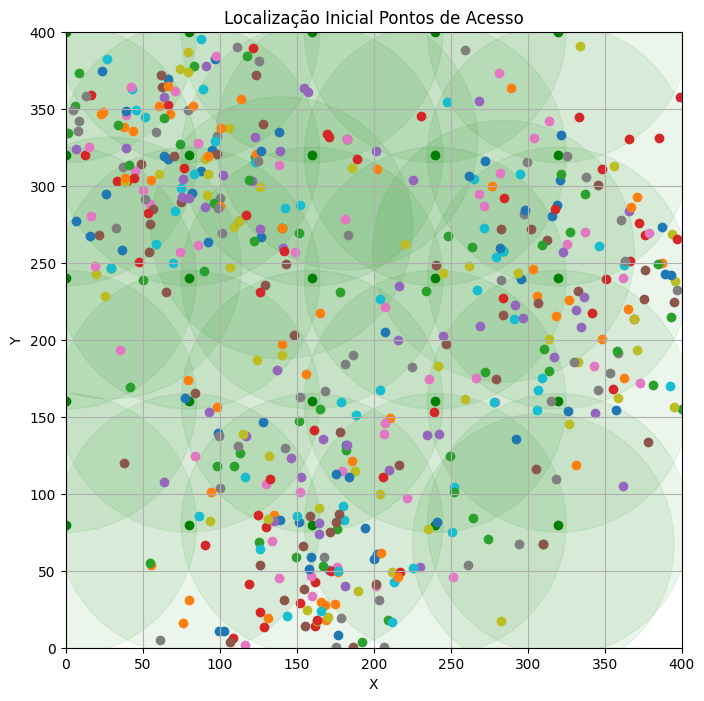

In [396]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in solution.pas.items():
    x, y = mapear_coordenadas(valor.x, valor.y)
    plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
    circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
    plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in solution.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'green' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor)  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title('Localização Inicial Pontos de Acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [625]:
import copy
temp_solution = copy.deepcopy(solution)
def initial_solution(solution) -> Solution:
    temp_solution = copy.deepcopy(solution)
    remaining_pas = max_access_points - len(temp_solution.pas.keys())
    for client in temp_solution.clients:
        counter = 0
        size_pas = len(temp_solution.pas.keys())
        index = random.randrange(0, size_pas)

        for client in temp_solution.clients:
            for pa in temp_solution.pas.values():
                if client.pa is None and temp_solution.try_connect_user(pa.id, client):
                   break
            if client.pa is None and remaining_pas > 0:
                pa_t = len(temp_solution.pas.keys())
                temp_solution.add_access_point(PontoAcesso(str(pa_t), client.x, client.y))
                size_pas = len(temp_solution.pas.keys())
                temp_solution.try_connect_user(str(pa_t), client)
                remaining_pas -= 1

    return temp_solution


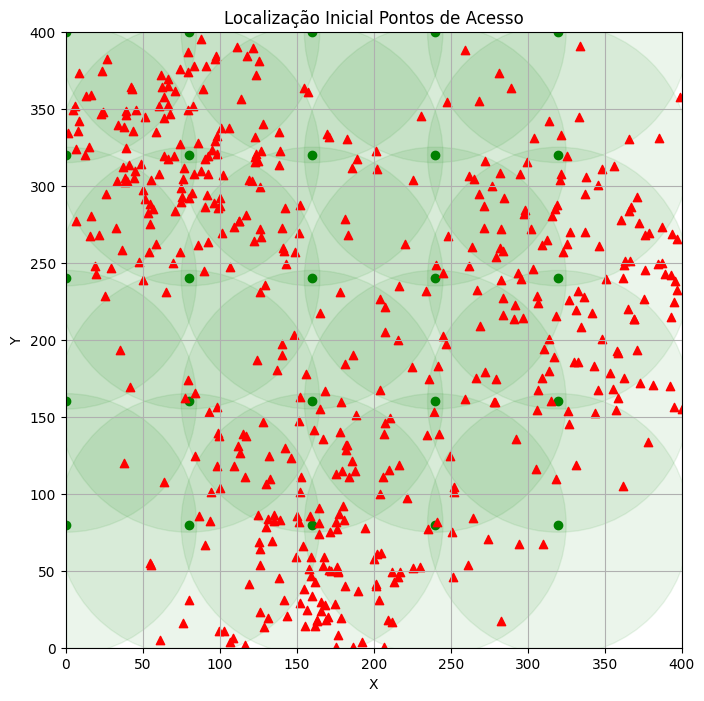

In [626]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in temp_solution.pas.items():
    x, y = mapear_coordenadas(valor.x, valor.y)
    plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
    circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
    plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in temp_solution.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title('Localização Inicial Pontos de Acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [493]:
# for client in temp_solution.clients:
#     print(client.pa)

print(temp_solution.pas)

{'0': PontoAcesso(x=0, y=0, capacidade=28.959215999999998, usuarios_conectados=[<__main__.Client object at 0x0000016F1CD882B0>, <__main__.Client object at 0x0000016F1CD7BF70>, <__main__.Client object at 0x0000016F1CE00130>, <__main__.Client object at 0x0000016F1CE00250>, <__main__.Client object at 0x0000016F1CE00520>, <__main__.Client object at 0x0000016F1CE00760>, <__main__.Client object at 0x0000016F1CE00B50>, <__main__.Client object at 0x0000016F1CE00BE0>, <__main__.Client object at 0x0000016F1CE00D90>, <__main__.Client object at 0x0000016F1CE00F40>, <__main__.Client object at 0x0000016F1CE00FD0>, <__main__.Client object at 0x0000016F1CE031C0>, <__main__.Client object at 0x0000016F1CE03400>, <__main__.Client object at 0x0000016F1CE03490>, <__main__.Client object at 0x0000016F1CE03640>, <__main__.Client object at 0x0000016F1CE036D0>, <__main__.Client object at 0x0000016F1CE03880>, <__main__.Client object at 0x0000016F1CE03A30>, <__main__.Client object at 0x0000016F1CE03AC0>, <__main_

In [492]:
initial_solution()

True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
False
True
False
True
True
True
True
True
False
False
True
True
True
True
True
True
False
True
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
False
True
False
False
True
False
False
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
False
True
True
True
True
True
False
False
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
False
True
False
True
True
True
True
True
False
True
True
False
True
True
True
True
True
False
True
False
False
False
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
False
True
True
True
True
True
True
False
False
False
True
True
True
True
True
True
False
True
True
True
True
True
True
False
False
True
True
True
True
True
True
T

In [655]:
def check_demand_coverage(solution: Solution):
    covered_clients = 0
    for key, value in solution.pas.items():
        covered_clients += value.users_connected()

    counter = 0
    for client in solution.clients:
        if client.pa is not None:
            counter += 1
    client_cvg_ratio = counter / num_clients
    coverage_ratio = covered_clients / num_clients
    return client_cvg_ratio > 0.98

In [494]:
print(check_demand_coverage(temp_solution))

1.0


In [3]:
# Ler dados do arquivo CSV e normalizar coordenadas
client_coordinates, bandwidth_demands = read_and_normalize_data('clientes.csv')
len(client_coordinates), len(bandwidth_demands)

(495, 495)

In [271]:
# Função objetivo 1: minimizar o número de pontos de acesso
def objective_function_1(solution: Solution):
    return solution.active_access_point()

# Função objetivo 2: minimizar a distância entre pontos de acesso e clientes
def objective_function_2(solution: Solution):
    return solution.total_distance()

In [499]:
objective_function_1(temp_solution)

28

In [500]:
objective_function_2(temp_solution)

28967.757966077683

In [652]:
import copy

# Explorar vizinhança (swap)
def explore_neighborhood_swap(solution: Solution):
    new_solution = copy.deepcopy(solution)
    i = random.randint(0, len(new_solution.pas.keys()) - 1)
    disconnected_users = []
    for user_connected in new_solution.pas[str(i)].usuarios_conectados:
        new_solution.disconnect_user(str(i), user_connected)
        disconnected_users.append(user_connected)
    
    for user in disconnected_users:
        for pas in new_solution.pas.values():
            if pas.is_active() and new_solution.try_connect_user(pas.id, user):
                disconnected_users.remove(user)
                break
    return new_solution

def explore_neighborhood_exchange(solution: Solution):
    temp_solution = copy.deepcopy(solution)
    users_connected = math.inf
    for pa in temp_solution.pas.values():
        if pa.is_active() and len(pa.usuarios_conectados) < users_connected:
            least_used_pa = pa.id
    
    disconnected_users = temp_solution.pas[least_used_pa].usuarios_conectados
    for user in disconnected_users:
        temp_solution.disconnect_user(least_used_pa, user)

    for user in disconnected_users:
        for pa in temp_solution.pas.values():
            if temp_solution.try_connect_user(pa.id, user):
                break
    return temp_solution

# Explorar vizinhança (inserção)
def explore_neighborhood_insert(solution: Solution):
    new_solution = copy.deepcopy(solution)
    unatendent_clients = [
        client
        for client in new_solution.clients
        if client.pa is None
    ]
    
    
    if len(unatendent_clients) > 0:
        selected_client = random.choice(unatendent_clients)
        selected_pa = random.choice(list(new_solution.pas.keys()))

        new_solution.pas[str(selected_pa)].x = selected_client.x
        new_solution.pas[str(selected_pa)].y = selected_client.y

        for client in new_solution.pas[selected_pa].usuarios_conectados:
            new_solution.disconnect_user(selected_pa, client)
            unatendent_clients.append(client)

        for user in unatendent_clients:
            for pas in new_solution.pas.values():
                if pas.is_active() and new_solution.try_connect_user(pas.id, user):
                    unatendent_clients.remove(user)
                    break

        return new_solution
    return solution

# Explorar vizinhança (reversão)
# def explore_neighborhood_reverse(solution: Solution):
#     new_solution = copy.deepcopy(solution)
#     i1, i2 = random.sample(range(max_access_points), 2)  # Seleciona dois índices aleatórios
#     new_solution['y'][i1], new_solution['y'][i2] = new_solution['y'][i2], new_solution['y'][i1]  # Troca os estados dos pontos de acesso
#     return new_solution

In [644]:
import copy

def shake(x: Solution, k: int):
    
    y = copy.deepcopy(x)
    
    if k == 3:             # apply not operator in one random position
        y = explore_neighborhood_insert(y)
        
    elif k == 2:           # apply not operator in two random positions        
        y = explore_neighborhood_exchange(y)
        
    elif k == 1:           # apply not operator in three random positions
        y = explore_neighborhood_swap(y)      
    
    return y

In [672]:
def local_search(solution: Solution):
    new_solution = copy.deepcopy(solution)
    client = random.choice(new_solution.clients)

    nearest_pa_distance = math.inf
    nearest_pa_id = -1
    for pa in new_solution.pas.values():
        if pa.is_active() and pa.distance(client.x, client.y) < nearest_pa_distance:
            nearest_pa_distance = pa.distance(client.x, client.y)
            nearest_pa_id = pa.id
    
    if (nearest_pa_id is not client.pa and nearest_pa_distance < max_distance):
        if client.pa is None or new_solution.disconnect_user(client.pa, client):
            new_solution.try_connect_user(nearest_pa_id, client)

    return new_solution

In [ ]:
def neighborhoodChange(x, y, k):
    
    if y < x.single_objective_value:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

In [663]:
# Função RVNS (Reactive Variable Neighborhood Search) generalizada
def rvns(max_iterations, max_iterations_no_improve, objective_function):
    # Inicializar solução aleatória
    clients = [
    Client(client_id, coordinates[0], coordinates[1], band)
    for client_id, (coordinates, band) in enumerate(zip(client_coordinates, bandwidth_demands))
    ]   
    
    import random 

    pas_dict = {}
    steps = int(grid_size/used_distance)
    t = 0
    for i in range(0, steps):
        for n in range (0, steps):
            pas_dict[str(t)] =  PontoAcesso(str(t), (i)*used_distance, (n)*used_distance)
            t += 1

    temp_solution = Solution(pas_dict, clients)
    solution = initial_solution(temp_solution)
    best_solution = copy.deepcopy(solution)
    best_fitness = objective_function(solution)

    iteration = 0
    k_max = 3
    new_solution = copy.deepcopy(best_solution)
    while iteration < max_iterations:
        iteration += 1
        iteration_no_improve = 0
        k = 1

        while k <= k_max:
            print('K ', k)
            iteration_no_improve += 1
            new_solution = local_search(new_solution)
            new_solution = shake(new_solution, k)
            # Explorar vizinhança
            #new_solution, k = neighborhood_function(solution)

            # Avaliar a nova solução
            new_fitness = objective_function(new_solution)
            print(best_fitness)
            # Aceitar ou rejeitar a nova solução
            if (new_fitness < best_fitness) and check_demand_coverage(new_solution):
                k = 1
                best_solution = copy.deepcopy(new_solution)
                best_fitness = new_fitness
                iteration_no_improve = 0  # Resetar contador de iterações sem melhora
            else: 
                k += 1
        # Atualizar solução com a melhor encontrada
        solution = copy.deepcopy(best_solution)

    return best_solution, best_fitness

In [673]:
a, b = rvns(8000, 10, objective_function_1)


K  1
27
K  2
27
K  3
27
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26
K  3
26
K  1
26
K  2
26


In [681]:
print(check_demand_coverage(a))
counter = 0
for client in a.clients:
    if client.pa is not None:
        counter += 1
client_cvg_ratio = counter / num_clients

print(f'{client_cvg_ratio}% clientes conectados')

True
0.9818181818181818% clientes conectados


In [662]:

t = a

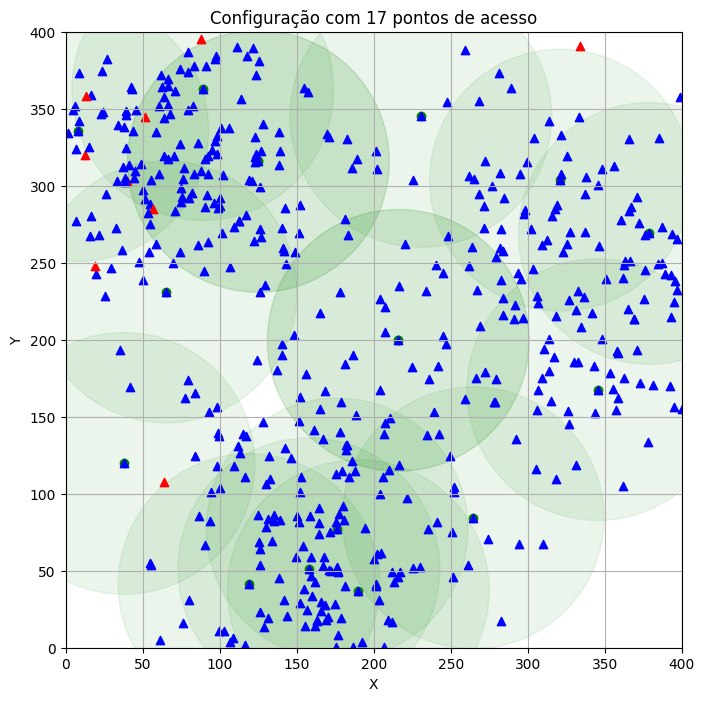

In [678]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in t.pas.items():
    if(valor.is_active()):
        x, y = mapear_coordenadas(valor.x, valor.y)
        plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
        circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
        plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in t.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'blue' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title(f'Configuração com {t.active_access_point()} pontos de acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [680]:
c, d = rvns(6000, 10, objective_function_2)


K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.757966077683
K  1
28967.757966077683
K  2
28967.757966077683
K  3
28967.75796

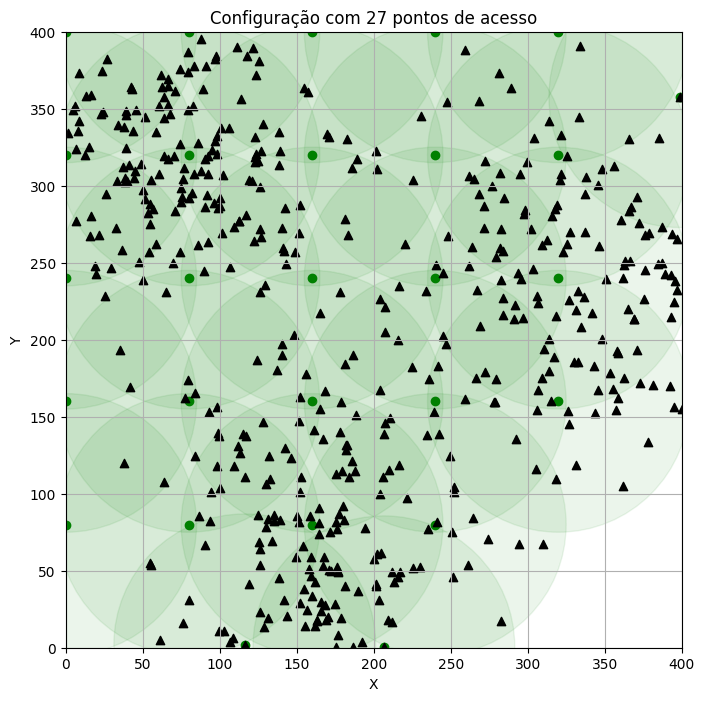

In [682]:
from matplotlib.patches import Circle

def mapear_coordenadas(x, y):
    return x, 400 - y  # Invertendo a coordenada y para corresponder à orientação do Matplotlib

plt.figure(figsize=(8, 8))  # Tamanho do gráfico (em polegadas)

# Iterar sobre os itens do dicionário e desenhar os pontos
for chave, valor in c.pas.items():
    if(valor.is_active()):
        x, y = mapear_coordenadas(valor.x, valor.y)
        plt.scatter(x, y, label=chave, color='green')  # Desenha o ponto
        circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85
        plt.gca().add_patch(circle)  # Adiciona o círculo ao gráfico

for client in c.clients:
    x, y = mapear_coordenadas(client.x, client.y)
    cor = 'black' if client.pa is not None else 'red'
    plt.scatter(x, y, label=chave, color=cor, marker='^')  # Desenha o ponto
    #circle = Circle((x, y), radius=85, color='green', fill=True, alpha=0.08)  # Círculo com raio de 85

# Configurações do gráfico
plt.xlim(0, 400)  # Limites do eixo x
plt.ylim(0, 400)  # Limites do eixo y
plt.xlabel('X')  # Rótulo do eixo x
plt.ylabel('Y')  # Rótulo do eixo y
plt.title(f'Configuração com {c.active_access_point()} pontos de acesso')  # Título do gráfico
#plt.legend()  # Mostrar legenda

# Exibir o gráfico
plt.grid(True)  # Habilita a grade
plt.gca().set_aspect('equal', adjustable='box')  # Mantém a escala igual nos eixos x e y
plt.show()


In [683]:
print(f'Distância Total: {d} unidades')

Distância Total: 28967.757966077683 unidades


In [9]:
# NÃO ESTÁ ENCONTRANDO RESULTADOS COERENTES PARA NENHUMA ESTRUTURA DE VIZINHANÇA, CONFERIR TUDO!

# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_swap)
#best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_swap)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'swap' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'swap' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.])}
Melh

In [9]:
# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_insert)
best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_insert)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'insert' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'insert' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}
Me

In [10]:
# Parâmetros do RVNS
max_iterations = 50
max_iterations_no_improve = 10

# Executar RVNS
best_solution_1, best_fitness_1 = rvns(max_iterations, max_iterations_no_improve, objective_function_1, explore_neighborhood_reverse)
best_solution_2, best_fitness_2 = rvns(max_iterations, max_iterations_no_improve, objective_function_2, explore_neighborhood_reverse)

# Verificar cobertura de demanda
coverage_1 = check_demand_coverage(best_solution_1)
coverage_2 = check_demand_coverage(best_solution_2)

print("Usando 'reverse' como estrutura de vizinhança\n")
print("Para a função objetivo 1:")
print("Melhor solução encontrada:", best_solution_1)
print("Melhor aptidão encontrada:", best_fitness_1)
print("Cobertura de demanda atingida?", coverage_1)

print("Para a função objetivo 2:")
print("Melhor solução encontrada:", best_solution_2)
print("Melhor aptidão encontrada:", best_fitness_2)
print("Cobertura de demanda atingida?", coverage_2)

Usando 'reverse' como estrutura de vizinhança

Para a função objetivo 1:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Melhor aptidão encontrada: 0.0
Cobertura de demanda atingida? False
Para a função objetivo 2:
Melhor solução encontrada: {'x': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
M